## Project description

In this project I will explore the dataset 'Plant Data Set', and intuitively enough this dataset is about plants.
Data has been extracted from the USDA plants database. It contains all plants in the database and the states of USA and Canada (in addition to Greenland and St. Pierre and Miquelon) where they occur. Originally each row includes name of the plant followed by a list of state abbreviations where it is found.


In [46]:
import gc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.fpm import FPGrowth
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, Row, IntegerType, ArrayType, BooleanType
from pyspark.sql.functions import udf, broadcast, array
from scipy.stats import chi2_contingency
import seaborn as sns
from tqdm.notebook import tqdm

### Dataset abbreviations are found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/plants/stateabbr.txt)

To see connections between countries in addition to states I seperated the states into different lists based on country. It may be difficult to draw any conclusions since the number of states is highly unbalanced.

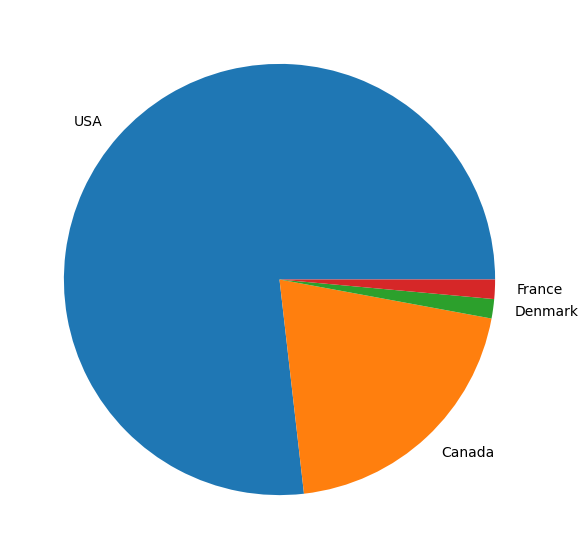

In [47]:
us_states = ['ab', 'ak', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'dc', 'fl', 'ga', 'hi', 'id', 'il', 'in', 'ia',
             'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm',
             'ny', 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'pr', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va',
             'vi', 'wa', 'wv', 'wi',
            'wy']

canada_states = ['al', 'bc', 'mb', 'nb', 'lb', 'nf', 'nt', 'ns', 'nu', 'on', 'pe', 'qc',
                 'sk', 'yt',]

denmark_state = ['dengl'] # Greenland

france_state = ['fraspm'] # St. Pierre and Miquelon


# Countries in dataset
countries = ['USA', 'Canada', 'Denmark',
        'France']

num_states = [len(us_states), len(canada_states), len(denmark_state), len(france_state)]

# Creating Pie chart based on states in each country
plt.figure(figsize =(10, 7))
plt.pie(num_states, labels = countries)

plt.show()

### Importing dataset
Dataset was downloaded from [Plant Data Set on uci](https://archive.ics.uci.edu/ml/machine-learning-databases/plants/plants.data) and placed in project root directory.


#### The data rows follow a pattern:

Name,list of states where it exists

abelia,fl,nc
abelia x grandiflora,fl,nc
abelmoschus,ct,dc,fl,hi,il,ky,la,md,mi,ms,nc,sc,va,pr,vi
abelmoschus esculentus,ct,dc,fl,il,ky,la,md,mi,ms,nc,sc,va,pr,vi
abelmoschus moschatus,hi,pr

To convert this into a usable dataframe I am going to set columns to name and all states and an integer 1 or 0 based on the plant occur in the state

In [48]:
# Start a Spark session
spark = SparkSession.builder.appName("CreateDF").master("local[*]").config("spark.executor.memory", "8g").config("spark.driver.memory", "8g").getOrCreate()

# Path to dataset
url = '../input/plant-data-set/plants.data'

state_abbreviations =  us_states + canada_states + denmark_state + france_state
features = ['name'] + state_abbreviations

# Read the CSV file into a RDD
rdd = spark.sparkContext.textFile(url)

# Define the schema for the DataFrame by extracting the unique features from the RDD
schema = StructType([StructField(features[0], StringType(), False)] +
                    [StructField(feature, IntegerType(), True) for feature in features[1:]])

# This generates a row from name + abbreviation list in the data
def gen_row(row):
    vals = row.split(',')

    # Vals[0] = name
    return Row(*(vals[0],) + tuple(1 if feature in vals else 0 for feature in features[1:]))


# Create the DataFrame from the RDD and schema
df = spark.createDataFrame(rdd.map(gen_row, schema), schema=schema)

# Show the first 15 columns and 5 first rows of the DataFrame
df.select(df.columns[:15]).show(5, False)

+----------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|name                  |ab |ak |ar |az |ca |co |ct |de |dc |fl |ga |hi |id |il |
+----------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|abelia                |0  |0  |0  |0  |0  |0  |0  |0  |0  |1  |0  |0  |0  |0  |
|abelia x grandiflora  |0  |0  |0  |0  |0  |0  |0  |0  |0  |1  |0  |0  |0  |0  |
|abelmoschus           |0  |0  |0  |0  |0  |0  |1  |0  |1  |1  |0  |1  |0  |1  |
|abelmoschus esculentus|0  |0  |0  |0  |0  |0  |1  |0  |1  |1  |0  |0  |0  |1  |
|abelmoschus moschatus |0  |0  |0  |0  |0  |0  |0  |0  |0  |0  |0  |1  |0  |0  |
+----------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
only showing top 5 rows



### Visualizing dataset
Show first 100 rows and the state abbreviations present for each as a binary image

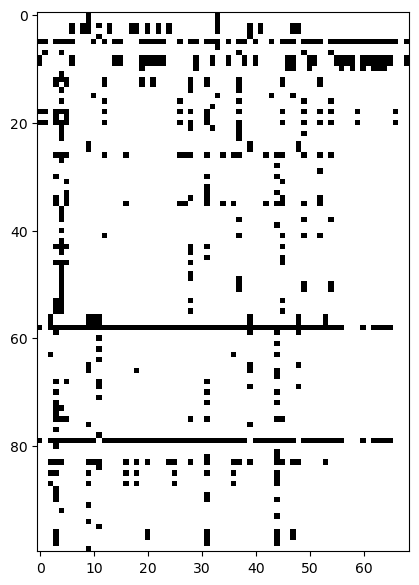

In [49]:
# Convert the DataFrame to a numpy array
first_100 = df.select(features[1:]).take(100)

# Plot binary matrix
plt.figure(figsize =(10, 7))
plt.imshow(first_100, cmap='binary')
plt.show()

del first_100

### Creating a correlation matrix between states

19

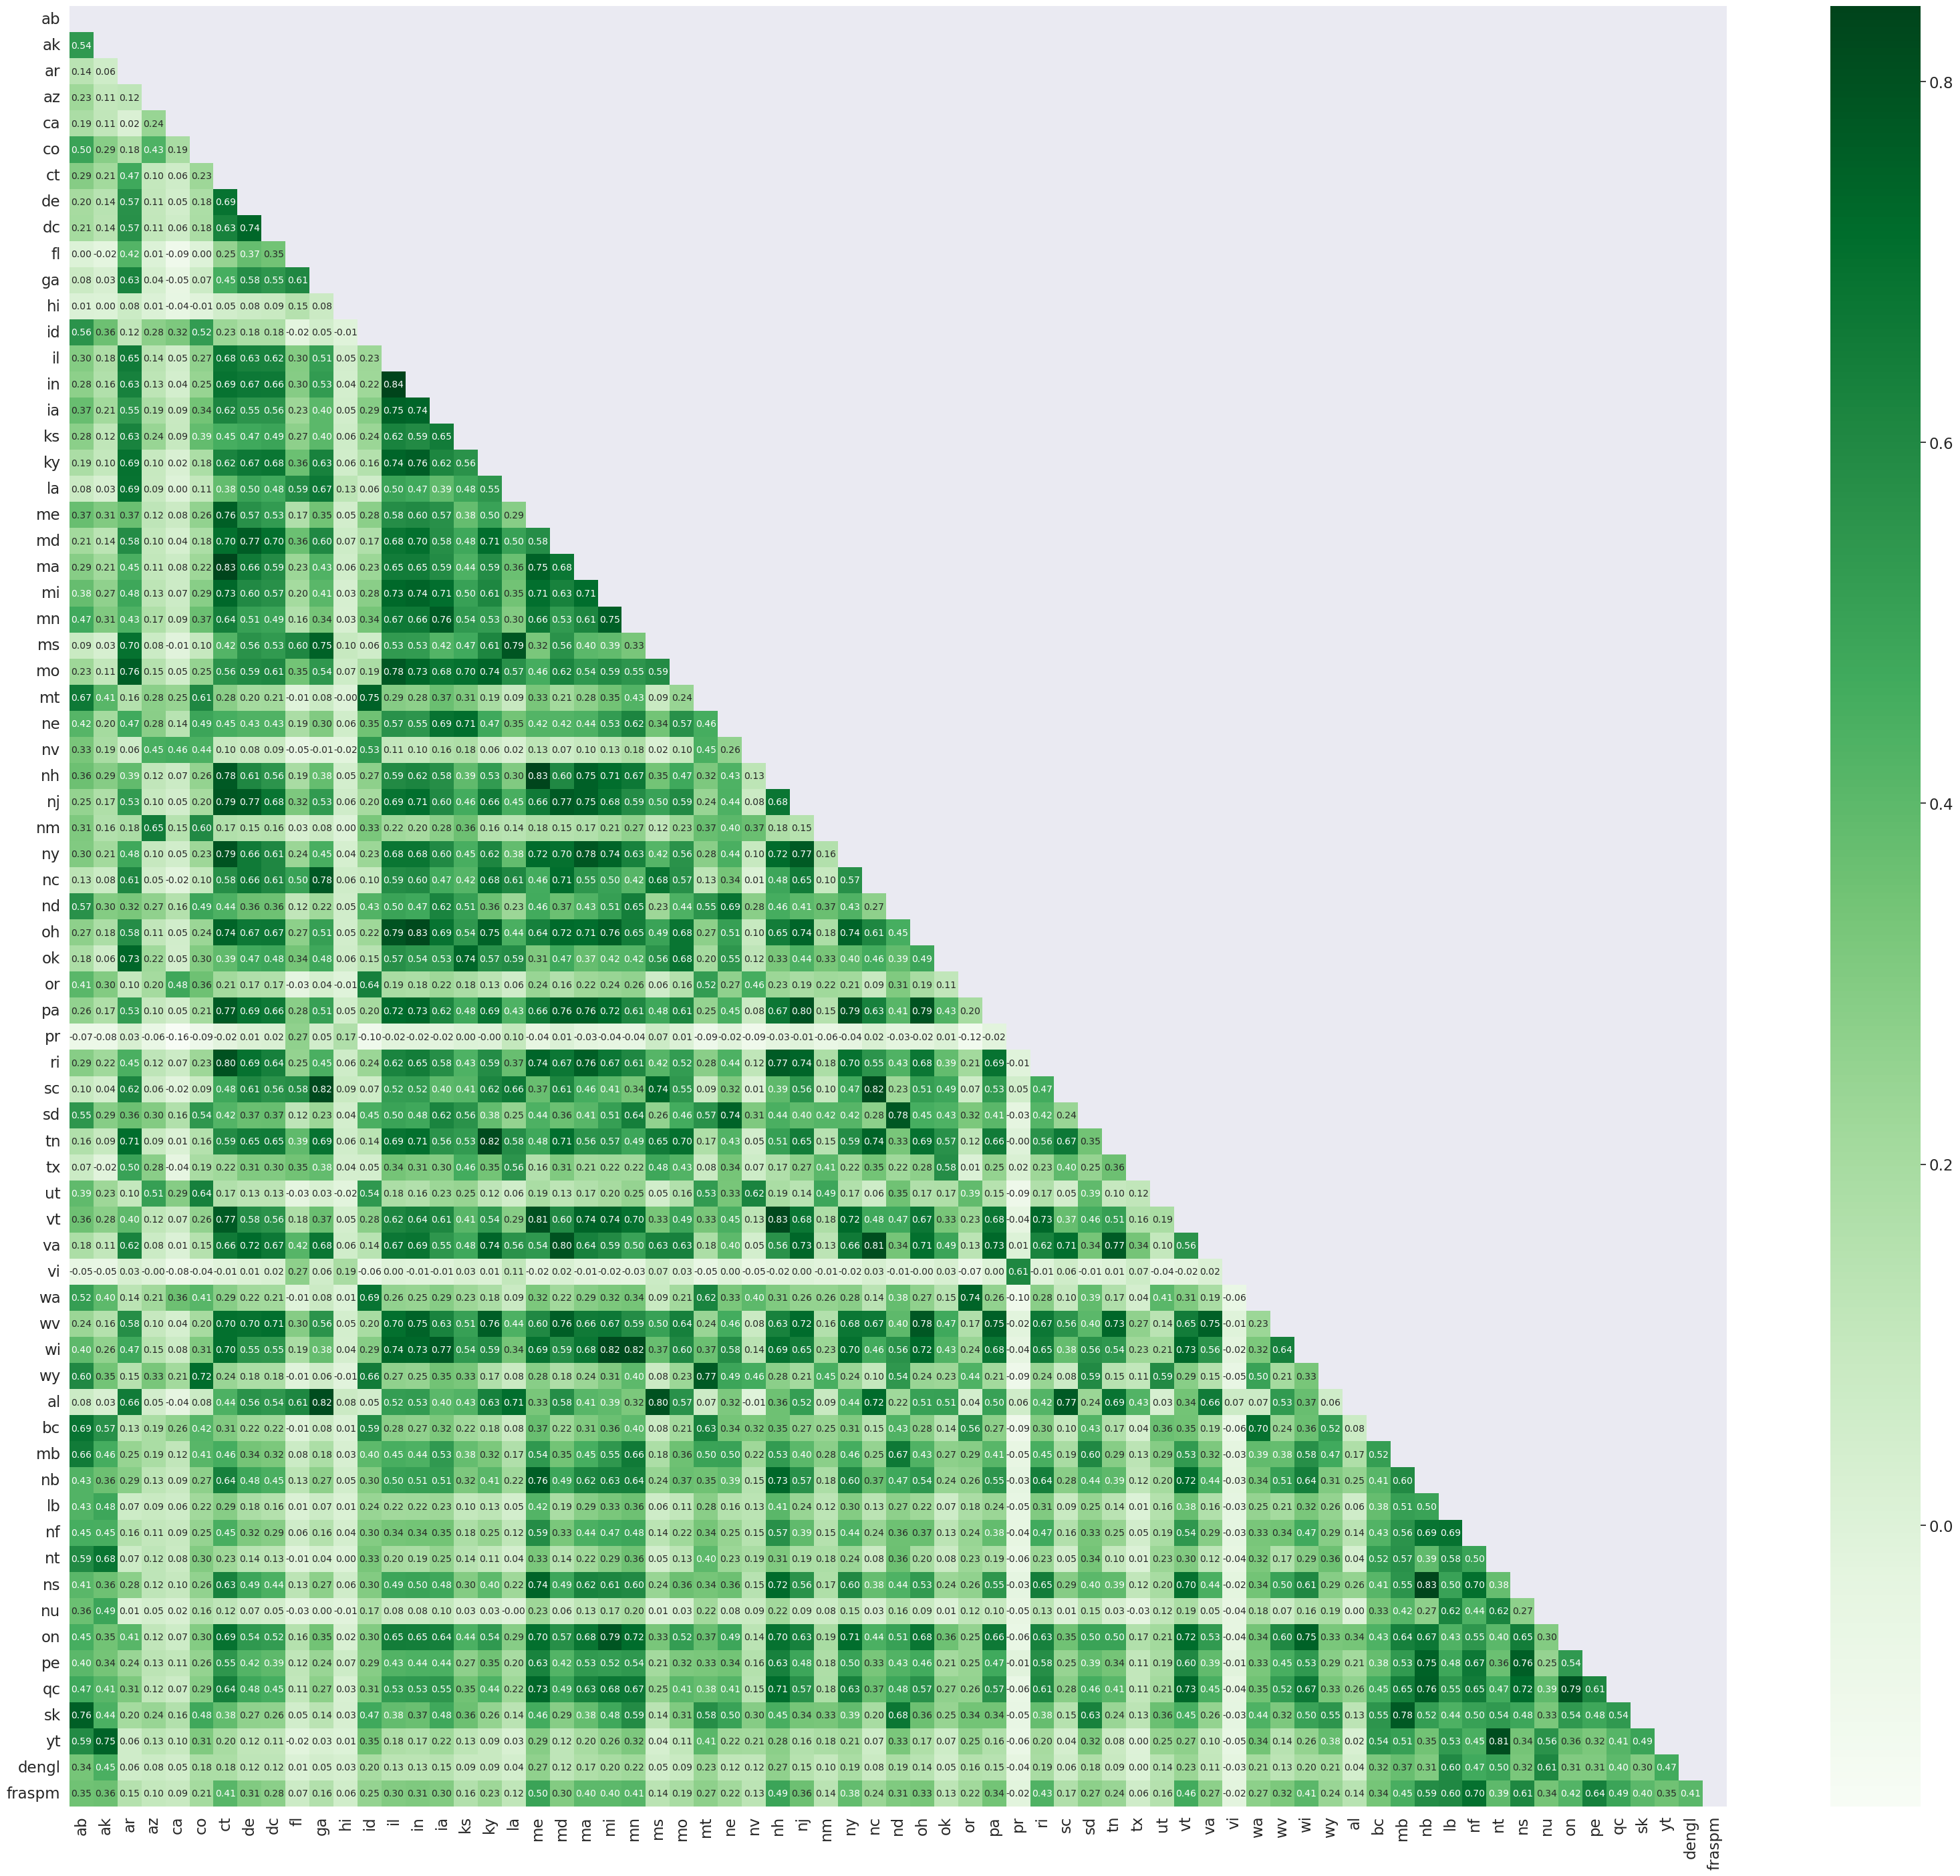

In [50]:
# Convert to vector column first
vector_col = "corr_vector"
assembler = VectorAssembler(inputCols=df.columns[1:], outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)


corr_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=state_abbreviations)

sns.set(font_scale=1.5)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(40,35))
sns.heatmap(corr_matrix_df,
            mask=mask,
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True, fmt=".2f", annot_kws={"size": 10})

del vector_col
del assembler
del df_vector
del corr_matrix
del corr_matrix_df
del mask
gc.collect()

### KMeans clustering

In [51]:
# Extract features for clustering (all columns except the first, which is the name of the plant)
assembler = VectorAssembler(inputCols=df.columns[1:], outputCol="features")
df_feature_vector = assembler.transform(df)

sum_squared_dist = []
K = range(2, len(state_abbreviations) + 1)
for k in tqdm(K):
    # Train a KMeans model with the k number of clusters
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(df_feature_vector)

    sum_squared_dist.append(model.summary.trainingCost)

  0%|          | 0/68 [00:00<?, ?it/s]

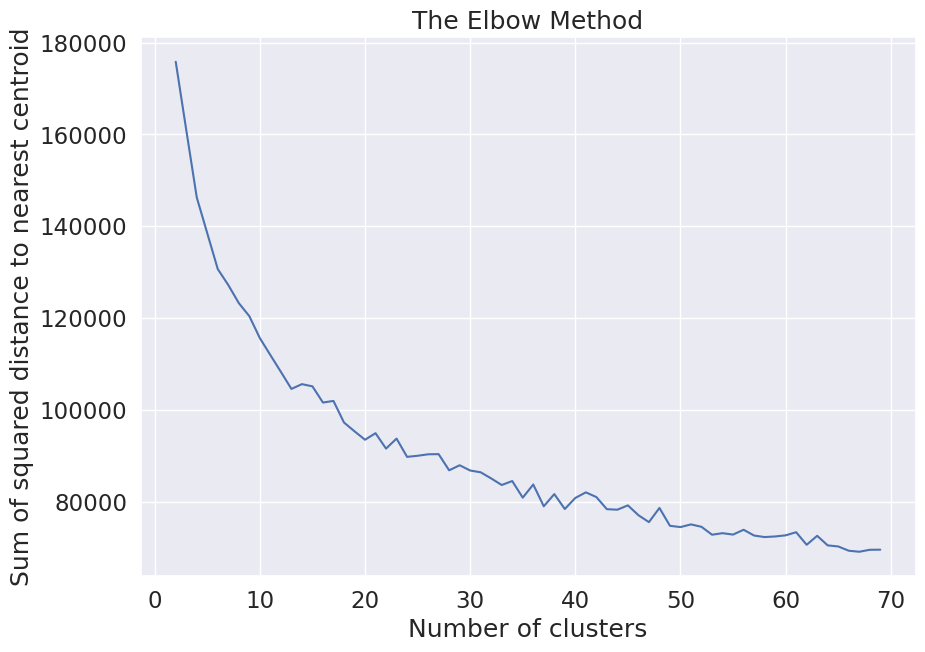

In [52]:
plt.figure(figsize =(10, 7))
plt.plot(K, sum_squared_dist)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance to nearest centroid')
plt.show()

Based on the plot we select k to be ...

In [53]:
optimal_clusters = 16

kmeans = KMeans(k=optimal_clusters, seed=1)
model = kmeans.fit(df_feature_vector)

# Predict the cluster for data point
predictions = model.transform(df_feature_vector)

# Show the resulting clusters
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|        12| 1076|
|         1|  375|
|        13| 2023|
|         6| 2676|
|         3|  726|
|         5|  996|
|        15|  887|
|         9|  560|
|         4|  608|
|         8| 1956|
|         7|  498|
|        10|  678|
|        11| 1924|
|        14| 5963|
|         2|  971|
|         0|12864|
+----------+-----+



23/02/15 05:20:01 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/02/15 05:20:01 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


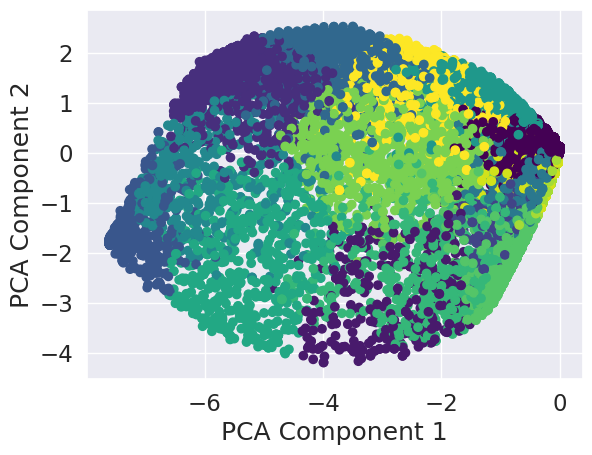

In [54]:
pca = PCA(k=3, inputCol="features")
pca.setOutputCol("pca_features")
model = pca.fit(predictions)

# Get the PCA features
pca_features = model.transform(predictions)
pca_features = pca_features.select("pca_features")


# Convert the PCA features to a numpy array
pca_np = np.array([x.__getitem__("pca_features") for x in pca_features.collect()])

# Plot the first two principal components
plt.scatter(pca_np[:, 0], pca_np[:, 1], c=predictions.select('prediction').collect(), cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

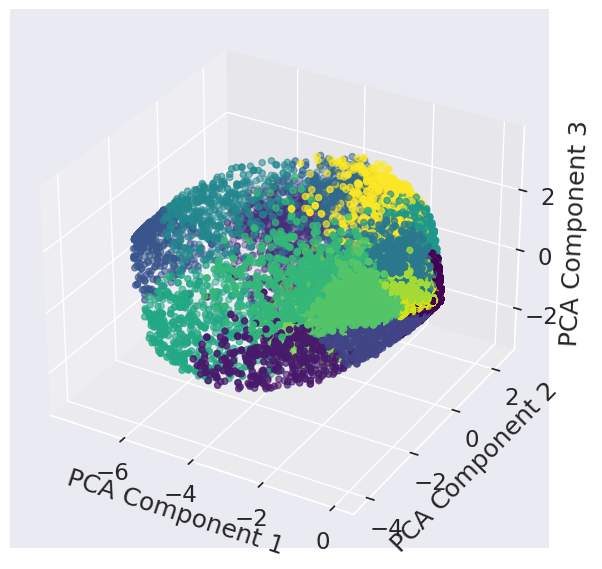

In [55]:
# To rotate plot use command below
# %matplotlib notebook

# Plot the first three principal components in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_np[:, 0], pca_np[:, 1], pca_np[:, 2], c=predictions.select('prediction').collect(), cmap='viridis')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()

### FPGrowth


In [56]:
del df
del assembler
del df_feature_vector
del features
del kmeans
del model
gc.collect()

86

In [59]:
# This generates a row from name + abbreviation list in the data
def gen_row(row):
    vals = row.split(",")
    return Row(vals[0], [state_abbreviations.index(val) for val in vals[1:]])

schema = StructType([StructField("name", StringType(), False),
                     StructField("state_idxs", ArrayType(IntegerType()), False)])

# Create the DataFrame from the RDD and schema
df_transactions = spark.createDataFrame(rdd.map(gen_row, schema), schema=schema)

df_transactions.show(5)


# Define the FPGrowth model
fpGrowth = FPGrowth(itemsCol="state_idxs", minSupport=0.1, minConfidence=0.9)

# Fit the FPGrowth model on the transactions data
model = fpGrowth.fit(df_transactions)


@udf(returnType=ArrayType(StringType()))
def get_states_abb_from_idxs(idxs):
    return [state_abbreviations[idx]for idx in idxs]

# Extract the frequent item sets from the model
frequent_item_sets = model.freqItemsets
frequent_item_sets.withColumn('item_abbr', get_states_abb_from_idxs(frequent_item_sets["items"])).show(20)

# Extract the association rules from the frequent item sets
association_rules = model.associationRules
association_rules.show(10)
association_rules.withColumn('a_abbr', get_states_abb_from_idxs(association_rules["antecedent"])).withColumn('c_abbr', get_states_abb_from_idxs(association_rules["consequent"])).show(10)

+--------------------+--------------------+
|                name|          state_idxs|
+--------------------+--------------------+
|              abelia|             [9, 33]|
|abelia x grandiflora|             [9, 33]|
|         abelmoschus|[6, 8, 9, 11, 13,...|
|abelmoschus escul...|[6, 8, 9, 13, 17,...|
|abelmoschus mosch...|            [11, 39]|
+--------------------+--------------------+
only showing top 5 rows



+--------------------+----+--------------------+
|               items|freq|           item_abbr|
+--------------------+----+--------------------+
|                [36]|4651|                [ok]|
|            [36, 44]|4104|            [ok, tx]|
|                [11]|3804|                [hi]|
|                [33]|5926|                [nc]|
|             [33, 9]|3696|            [nc, fl]|
|            [33, 10]|4833|            [nc, ga]|
|         [33, 10, 9]|3512|        [nc, ga, fl]|
|                [24]|4815|                [ms]|
|            [24, 33]|3912|            [ms, nc]|
|        [24, 33, 10]|3750|        [ms, nc, ga]|
|            [24, 47]|3566|            [ms, va]|
|             [24, 9]|3769|            [ms, fl]|
|            [24, 41]|3959|            [ms, sc]|
|        [24, 41, 33]|3698|        [ms, sc, nc]|
|    [24, 41, 33, 10]|3612|    [ms, sc, nc, ga]|
|        [24, 41, 10]|3827|        [ms, sc, ga]|
|        [24, 41, 53]|3805|        [ms, sc, al]|
|    [24, 41, 53, 33

+------------+----------+------------------+------------------+-------------------+
|  antecedent|consequent|        confidence|              lift|            support|
+------------+----------+------------------+------------------+-------------------+
|    [33, 10]|      [41]|0.9201324229257191|  5.89159164244835|0.12785716339380696|
|[41, 47, 33]|      [10]|0.9402654867256637| 5.503765380983728| 0.1099738362899284|
| [41, 53, 9]|      [10]|0.9708631115997801| 5.682866018941763|0.10154969667347115|
|[20, 38, 33]|      [47]|  0.97758095765292| 6.030727791437781|0.10154969667347115|
|[30, 20, 47]|      [38]|0.9373007438894793| 5.955472629378878|0.10143469135447515|
|    [54, 37]|      [49]|0.9676542538733351| 5.952596852488233|0.10235473390644317|
| [6, 21, 38]|      [32]|0.9851871801777539| 5.935526643644978|0.10517236422184525|
|[24, 18, 10]|      [53]|0.9675572519083969|5.9018956118249655|0.10203846927920417|
|[35, 13, 38]|      [32]|0.9357872111767866| 5.637903168532794|0.10014088151

In [58]:
@udf(returnType=BooleanType())
def chi_squared_test(antecedent, consequent, transactions):

    # Filter the transactions that contain the antecedent
    antecedent_transactions = transactions.filter(lambda x: all(item in x for item in antecedent))

    # Count the number of transactions that contain both the antecedent and the consequent
    antecedent_and_consequent_transactions = antecedent_transactions.filter(lambda x: consequent in x).count()

    # Count the number of transactions that contain the antecedent
    antecedent_transactions_count = antecedent_transactions.count()

    # Count the number of transactions that contain the consequent
    consequent_transactions_count = transactions.filter(lambda x: consequent in x).count()

    # Count the total number of transactions
    total_transactions_count = transactions.count()

    # Compute the contingency table for the rule
    contingency_table = [[antecedent_and_consequent_transactions, antecedent_transactions_count - antecedent_and_consequent_transactions],
                       [consequent_transactions_count - antecedent_and_consequent_transactions, total_transactions_count - antecedent_transactions_count - consequent_transactions_count + antecedent_and_consequent_transactions]]

    # Compute the chi-squared test statistic and p-value
    test_statistic, p_value, _, _ = chi2_contingency(contingency_table)

    # Return True if the p-value is less than a significance level (e.g. 0.05)
    return p_value < 0.05

# Future work try to implement chi2 testing to evaluate significance of rules generated by FPGrowth
# association_rules = association_rules.withColumn("new_col", chi_squared_test('antecedent', 'consequent', df_transactions['state_idxs']))
# association_rules.show(50)
